In [1]:
#Import neccesary packages
import torch
import numpy as np
import pandas as pd
import model
import data
import sklearn
import pickle
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pylab
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
import collections
import gzip

# Pretrained Word Embeddings

Using pretrained GloVe 6 Billion Tokens embeddings

To download, please go to: http://nlp.stanford.edu/data/glove.6B.zip

To download more complex version: https://nlp.stanford.edu/projects/glove/

In [2]:
#Specify GloVe embeddings files directory
glove_home = '../../datasets/glove.6B/'

#Import only a portion of words for testing
words_to_load = 50000

import numpy as np

#Using 50 dimension embeddding for testing
with open(glove_home + 'glove.6B.50d.txt') as f:
    loaded_embeddings = np.zeros((words_to_load, 50))
    words = {}
    ordered_words = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        
        s = line.split()
        loaded_embeddings[i, :] = np.asarray(s[1:])
        words[s[0]] = i
        ordered_words.append(s[0])

In [3]:
#save 100 dimension embeddings
with open(glove_home + 'glove.6B.100d.txt') as f:
    loaded_embeddings_100d = np.zeros((words_to_load, 100))
    words_100d = {}
    ordered_words_100d = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        
        s = line.split()
        loaded_embeddings_100d[i, :] = np.asarray(s[1:])
        words_100d[s[0]] = i
        ordered_words_100d.append(s[0])

To access the word embedding of certain word use the format loaded_embedings[words['someword']]

In [4]:
#Example:
loaded_embeddings[words['something']]

array([ 0.39533  , -0.0064782, -0.26112  , -0.32292  ,  0.96181  ,
        0.11242  , -0.30927  ,  0.17085  , -0.38948  ,  0.77584  ,
       -0.31334  ,  0.54971  , -0.4579   ,  0.05835  ,  1.0643   ,
        0.57949  ,  0.74198  ,  0.22064  ,  0.11507  , -0.84422  ,
       -0.43365  ,  0.52626  ,  0.067037 ,  0.16294  ,  1.1345   ,
       -2.0336   , -1.211    ,  0.69115  ,  1.418    , -0.80188  ,
        3.0172   ,  0.36111  , -0.38275  , -0.51099  , -0.19531  ,
       -0.16375  , -0.024037 ,  0.32332  , -0.0070115, -0.49139  ,
       -0.28394  ,  0.06881  , -0.11819  ,  0.47825  ,  0.16551  ,
        0.29805  ,  0.010174 ,  0.20346  , -0.13682  ,  0.79782  ])

# How to access saved model and its embedding
(For t-SNE plotting)
An example of trained model file outputed by main.py can be obtained by simply running 
python main.py

In [6]:
test_model = torch.load('../../datasets/LSTM_1250_1250_tied_0.65.pt')

In [7]:
#Access embedding encoder
embeddings = test_model.encoder

In [9]:
#Access the embedding of certain index
#Create a index tensor
index = torch.autograd.Variable(torch.cuda.LongTensor([1]))
#use embeddings(index)
print(embeddings(index).data.cpu().numpy())

[[ 0.07147868  0.03646019 -0.03048867 ...,  0.01924909 -0.0136376
  -0.0771784 ]]


In [10]:
embeddings.weight.data


-5.4350e-02 -7.6253e-03 -2.9374e-02  ...   4.7515e-02  2.8029e-02 -7.0857e-02
 7.1479e-02  3.6460e-02 -3.0489e-02  ...   1.9249e-02 -1.3638e-02 -7.7178e-02
 8.0481e-02  1.2258e-01 -9.6451e-02  ...  -7.4125e-02  7.0022e-02  1.6076e-02
                ...                   ⋱                   ...                
-4.9423e-02  1.0117e-01  4.0854e-03  ...  -3.9028e-02 -2.0268e-01  1.8963e-01
-4.3125e-02  6.2225e-03  6.2261e-02  ...  -1.1452e-01  7.3214e-02  2.3005e-02
-1.8368e-01  1.4102e-01 -3.1606e-02  ...  -1.1025e-01  1.6185e-01  5.8586e-02
[torch.cuda.FloatTensor of size 10000x1250 (GPU 0)]

In [23]:
# Or load saved infosheets Python 3.5 needed
#import pickle
#with open('../../datasets/LSTM_1250_1250_tied_0.65.pk')as f:
#    info = pickle.load(f)

# data.Corpus()

In [11]:
corpus_penn = data.Corpus('./data/penn/')
#corpus_gutenberg = data.Corpus('./data/gutenberg_processed/')

In [7]:
#Solve the python 3.5 decoding issue of guttenberg
#f = open('../../datasets/corpus_gutenberg.pk','wb')
#pickle.dump(file=f,obj=corpus_gutenberg)

In [12]:
f = open('../../datasets/corpus_gutenberg.pk','rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
corpus_gutenberg = u.load()

In [13]:
f.close()

Corpus.dictionary module comes with handy lookup function between words and their associated index.

# Embedding Initialization

Can use the following codes to initialize embeddings weight before training. For those words does not existed in loaded pretrained GloVe embeddings, initialized them with uniform distribution between -1 and 1.

In [96]:
initial_emb_weights = np.zeros(10000*50).reshape(10000,50)
unitialized_words = []
for idx,word in enumerate(corpus.dictionary.idx2word):
    try:
        initial_emb_weights[idx,:] = loaded_embeddings[words[word]]
    except:
        unitialized_words.append(word)
        initial_emb_weights[idx,:] = np.random.uniform(size=50,low=-1,high=1)
np.save('penn_Glove_10000.npy',initial_emb_weights)

In [103]:
initial_emb_weights = np.zeros(10000*100).reshape(10000,100)
unitialized_words = []
for idx,word in enumerate(corpus.dictionary.idx2word):
    try:
        initial_emb_weights[idx,:] = loaded_embeddings_100d[words_100d[word]]
    except:
        unitialized_words.append(word)
        initial_emb_weights[idx,:] = np.random.uniform(size=100,low=-1,high=1)
np.save('penn_Glove_10000_100d.npy',initial_emb_weights)

Let's check how many words are initialized with pretrained embeddings.

In [104]:
'%s out of 10000' % (10000-len(unitialized_words))

'9290 out of 10000'

In [73]:
#Initialize embeddings in torch
testModel = model.RNNModel('LSTM', 10000, 50, 50, 2,0.5)
testModel.cuda()

RNNModel (
  (encoder): Embedding(10000, 50)
  (rnn): LSTM(50, 50, num_layers=2, bias=False)
  (decoder): Linear (50 -> 10000)
  (dropout): Dropout (p = 0.5)
)

In [76]:
initial_emb_weights = np.load('penn_Glove_10000.npy')
testModel.encoder.weight.data.copy_(torch.from_numpy(initial_emb_weights))


 1.2976e+00 -6.8898e-01  5.8863e-02  ...   1.5561e+00  1.2506e-01  6.1730e-01
-7.7372e-01 -4.3496e-01  4.9961e-01  ...   1.0488e+00 -3.9849e-02 -7.0361e-01
-8.5009e-01 -7.1816e-01 -7.6551e-01  ...  -2.3225e-01  1.1812e-01  6.7138e-02
                ...                   ⋱                   ...                
 9.6991e-01  2.6161e-01  1.2579e+00  ...   5.7370e-01 -1.2297e+00  6.4438e-01
-1.6767e-01 -7.0546e-01  3.8829e-01  ...   3.7024e-01 -2.6469e-01  5.2524e-01
 5.7114e-01  2.2081e-01 -9.1496e-01  ...   1.3575e-01 -3.7129e-01  4.2618e-02
[torch.cuda.FloatTensor of size 10000x50 (GPU 0)]

# t-sne ploting

### Using t-stochastic neighbour embeddings (t-SNE) algorithm, we can easily build a 2-dimension representation of our trained high-dimension embeddings. We expect the 'similar' words to exist in similar context and we hope that the 2-dimension representation of our embeddings also shows this syntatic similarity by Euclidean distances in 2-D. 

Ignore the following lines if we are using numpy embedding weights file.

In [77]:
# Using sklearn.manifold.TSNE package
# Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
#index_to_plot = torch.autograd.Variable(torch.LongTensor(np.arange(0,50,1)))
#Embeddings_to_plot = embeddings(index_to_plot).data

Let's check how well GloVe represents words cluster

In [78]:
####Using preloaded embeddings
Embeddings_to_plot = initial_emb_weights

Use TSNE package to get the 2D representations of embeddings.

In [93]:
from sklearn.manifold import TSNE
TSNE_model = TSNE(n_components=2,random_state=0)

In [80]:
#Transfer to 2 dimensions
representations2D = TSNE_model.fit_transform(Embeddings_to_plot)

In [81]:
#words_to_plot = corpus.dictionary.idx2word[:50]

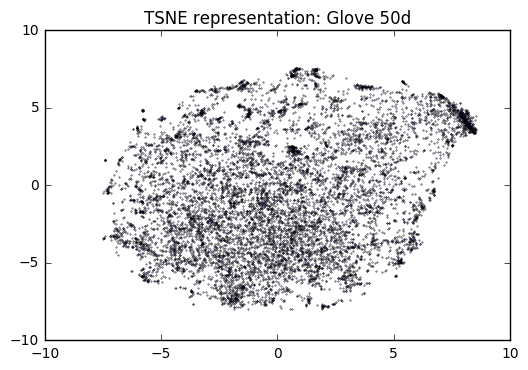

In [82]:
plt.scatter(representations2D[:,0],representations2D[:,1],s=0.1)
#for word_idx,word in enumerate(words_to_plot):
#    plt.annotate(word,representations2D[word_idx])
#plt.xlim([-100,100])
#plt.ylim([-100,100])
plt.title('TSNE representation: Glove 50d')
plt.show()

Let's Look at some trained embeddings diagram

In [94]:
with open('../../datasets/LSTM_1250_1250_tied_0.65.pk','rb') as f:
            info_dict = pickle.load(f)
Embeddings_LSTM_1250_1250_tied_065 = info_dict['embeddings']
representations2D_penn = TSNE_model.fit_transform(Embeddings_LSTM_1250_1250_tied_065)

In [95]:
np.save('rep2D_Penn.npy',representations2D_penn)

In [97]:
f = open('../../datasets/LSTM_1250_1250_tied_0.65_gutenberg.pk','rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
info_dict = u.load()
Embeddings_LSTM_1250_1250_tied_065_gutenberg = info_dict['embeddings']
representations2D_gutenberg = TSNE_model.fit_transform(Embeddings_LSTM_1250_1250_tied_065_gutenberg)

In [98]:
np.save('rep2D_Penn.gutenberg',representations2D_gutenberg)

## Clustering of Embeddings

In [2]:
representations2D_gutenberg=np.load('../../datasets/tsne_representations/rep2D_Penn.gutenberg.npy')
representations2D_penn = np.load('../../datasets/tsne_representations/rep2D_Penn.npy')

In [3]:
kmeans_gutenberg = KMeans(init='k-means++', n_clusters=32, n_init=10)
kmeans_gutenberg.fit(representations2D_gutenberg)
kmeans_penn = KMeans(init='k-means++', n_clusters=30, n_init=10)
kmeans_penn.fit(representations2D_penn)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=30, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [4]:
def clusterPlot2D(rep2D,kmeans,savepath = 'TSNE_Plot',title='T-SNE representations'):
    plt.figure(figsize=(20,20))
    pylab.scatter(rep2D[:,0],rep2D[:,1],s=2,c=kmeans.labels_,cmap=pylab.cm.Accent)
    pylab.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='r')
    bbox_props = dict(boxstyle="rarrow", fc="cyan",pad=0.001, ec="b", lw=0.1)
    for center_idx,center in enumerate(kmeans.cluster_centers_):
        pylab.annotate(center_idx,center,bbox=bbox_props,rotation=45,va='top',ha='right')
    #for word_idx,word in enumerate(words_to_plot):
    #    plt.annotate(word,representations2D[word_idx])
    plt.title(title)
    plt.savefig('%s.png'%(savepath))
    plt.show()

In [16]:
def zoom(rep2D,kmeans,corpus,index_to_zoom,closest = 100):
    cluster_index = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    plt.figure(figsize=(10,10))
    specified_pos = np.where(cluster_index==index_to_zoom)[0]
    rep2D_to_plot = rep2D[specified_pos]
    #calculate the distances between each word and its cluster center
    center = cluster_centers[index_to_zoom]
    dist2ctr = cdist(center.reshape(-1,2),rep2D_to_plot.reshape(-1,2),'euclidean')[0]
    #Sort by Euclidean Dist
    mat = np.zeros(len(dist2ctr)*4).reshape(len(dist2ctr),4)
    mat[:,:2] = rep2D_to_plot
    mat[:,2] = dist2ctr 
    mat[:,3] = specified_pos
    sorted_mat = np.array(sorted(mat,key=lambda x:x[2]))
    first_N_rep = sorted_mat[:closest,:2]
    first_N_idx = [int(x) for x in sorted_mat[:closest,3]]
    words_to_annotate = [corpus.dictionary.idx2word[idx] for idx in first_N_idx]
    #pylab.scatter(rep2D_to_plot[:,0],rep2D_to_plot[:,1],s=2)
    pylab.scatter(first_N_rep[:,0],first_N_rep[:,1],s=2)
    pylab.scatter(cluster_centers[index_to_zoom][0],cluster_centers[index_to_zoom][1],c='r')
    for word_pos,coordinate in enumerate(first_N_rep):
        pylab.annotate(words_to_annotate[word_pos],coordinate)
    plt.show()
    return words_to_annotate

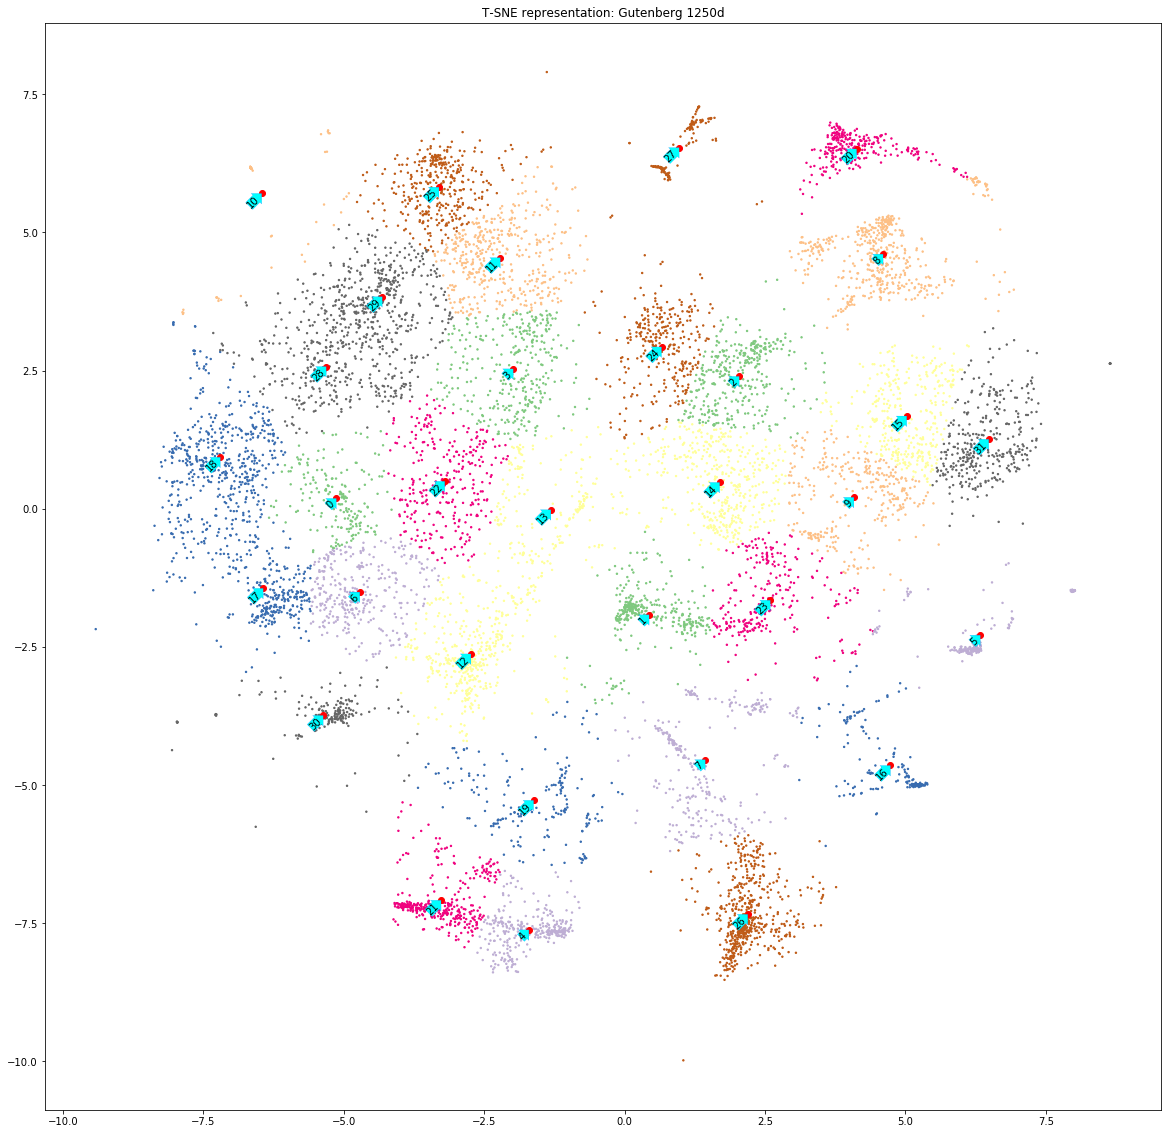

In [7]:
clusterPlot2D(representations2D_gutenberg,kmeans_gutenberg\
              ,savepath='tsne_gutenberg.png',title='T-SNE representation: Gutenberg 1250d')

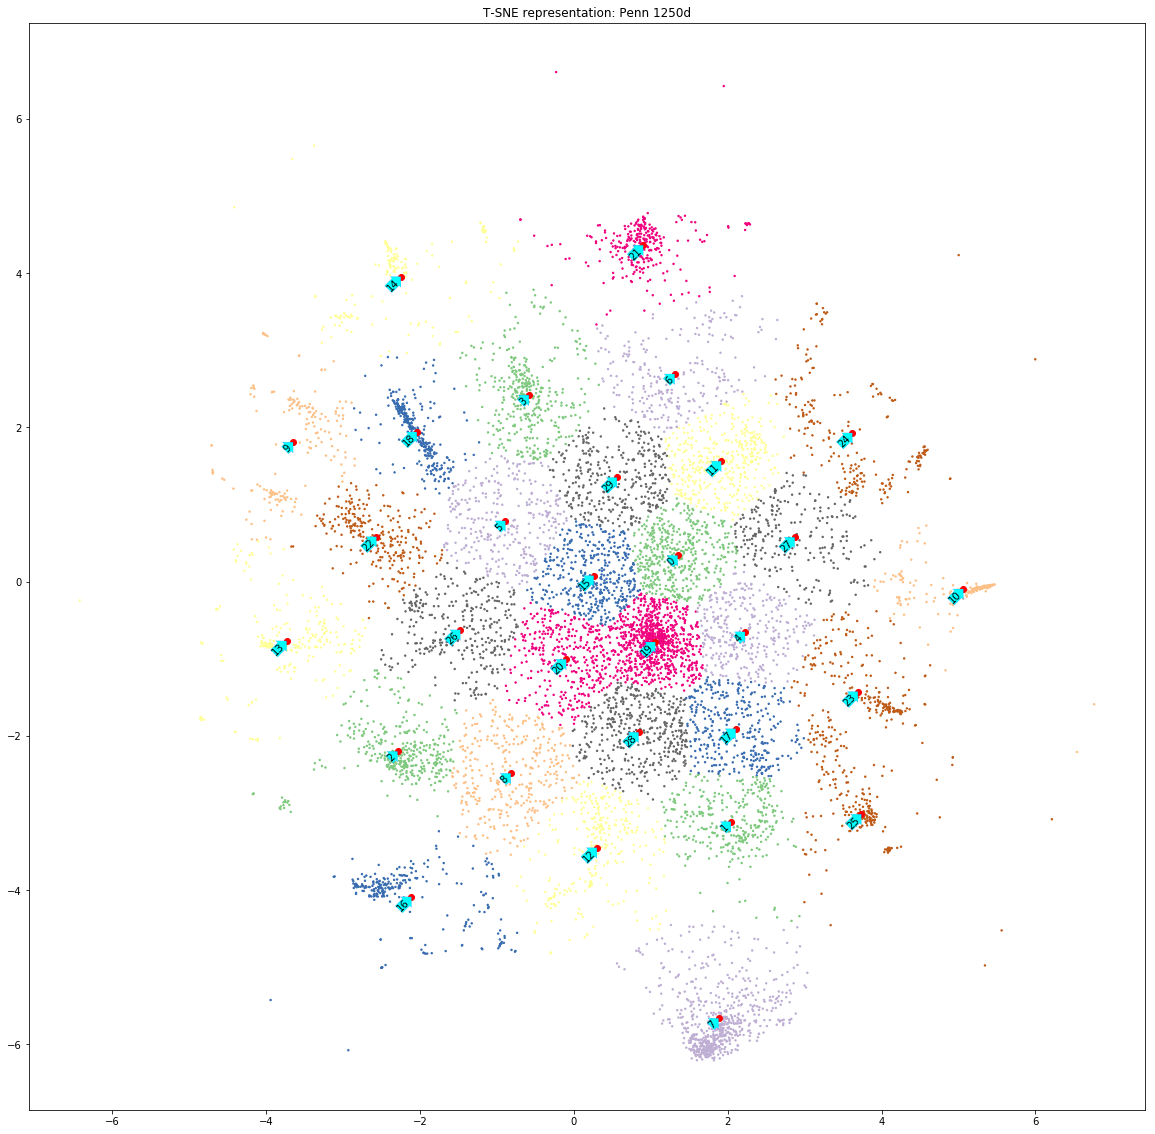

In [8]:
clusterPlot2D(representations2D_penn,kmeans_penn,savepath='tsne_penn.png',title='T-SNE representation: Penn 1250d')

We did see some significant cluster such as cluster 3 and cluster 12. We can investigate those clusters qualitatively and see whether the word embeddings represents some words syntatic relations.

# Zoom in to see cluster

## Cluster 30-Gutenberg : Plural of Nouns

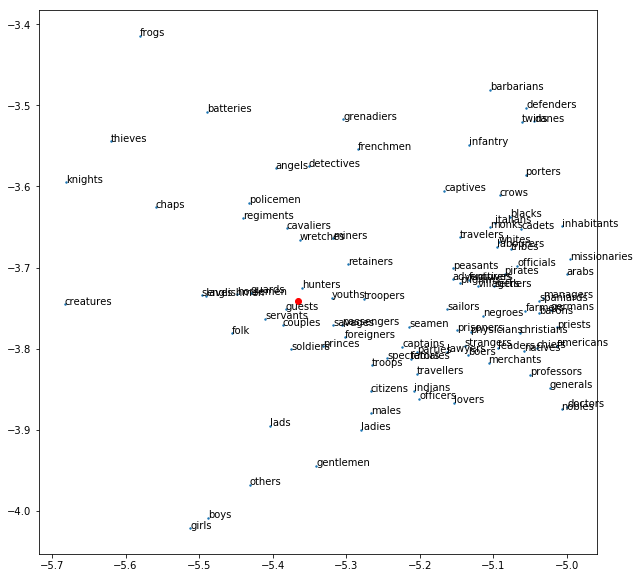

['hunters', 'guests', 'couples', 'youths', 'servants', 'savages', 'soldiers', 'guards', 'princes', 'passengers', 'wretches', 'foreigners', 'retainers', 'horsemen', 'troopers', 'miners', 'cavaliers', 'folk', 'englishmen', 'regiments', 'troops', 'slaves', 'policemen', 'spectators', 'citizens', 'captains', 'seamen', 'lads', 'angels', 'detectives', 'females', 'males', 'parties', 'ladies', 'travellers', 'indians', 'sailors', 'frenchmen', 'officers', 'gentlemen', 'lawyers', 'adventurers', 'peasants', 'prisoners', 'pilgrims', 'chaps', 'grenadiers', 'strangers', 'travelers', 'fugitives', 'others', 'physicians', 'captives', 'boers', 'villagers', 'lovers', 'negroes', 'batteries', 'settlers', 'merchants', 'monks', 'leaders', 'labourers', 'whites', 'pirates', 'italians', 'boys', 'tribes', 'officials', 'infantry', 'crows', 'christians', 'blacks', 'farmers', 'natives', 'cadets', 'girls', 'creatures', 'thieves', 'barons', 'spaniards', 'professors', 'chiefs', 'managers', 'germans', 'porters', 'knights

In [22]:
#Gutenberg
print(zoom(representations2D_gutenberg,kmeans_gutenberg,corpus_gutenberg,index_to_zoom=30,closest=100))

## Cluster 10-Penn: Name and alias

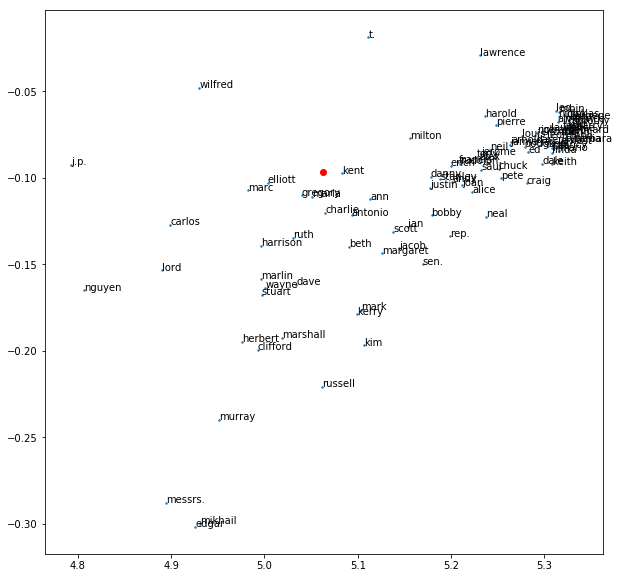

['maria', 'kent', 'charlie', 'gregory', 'antonio', 'ruth', 'beth', 'ann', 'elliott', 'dave', 'margaret', 'harrison', 'marc', 'scott', 'mark', 'kerry', 'marlin', 'wayne', 't.', 'jacob', 'milton', 'ian', 'stuart', 'marshall', 'kim', 'justin', 'danny', 'bobby', 'sen.', 'russell', 'clifford', 'stanley', 'herbert', 'erich', 'andy', 'rep.', 'wilfred', 'francis', 'rudolph', 'joan', 'alice', 'tony', 'carlos', 'alex', 'saul', 'jerome', 'neal', 'harold', 'neil', 'lawrence', 'lord', 'murray', 'pierre', 'chuck', 'pete', 'jamie', 'arnold', 'louis', 'doug', 'craig', 'ed', 'karen', 'rick', 'ray', 'dale', 'gerard', 'leon', 'ken', 'mikhail', 'keith', 'linda', 'laurence', 'pat', 'chris', 'edgar', 'nancy', 'leo', 'mario', 'alvin', 'nicholas', 'ernest', 'messrs.', 'robin', 'kevin', 'ted', 'cynthia', 'don', 'maurice', 'glenn', 'kurt', 'dick', 'joel', 'nguyen', 'ben', 'leonard', 'timothy', 'barbara', 'j.p.', 'eugene', 'barry']


In [24]:
print(zoom(representations2D_penn,kmeans_penn,corpus_penn,index_to_zoom=10,closest=100))